# Evaluating cloud dilation options for Landsat Fmask <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls9c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls9c_ard_3)



## Getting started

### Load packages
Import Python packages used for the analysis.


In [1]:
import datacube
from datacube.utils.masking import make_mask
from odc.algo import mask_cleanup

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.dask import create_local_dask_cluster

# Launch Dask cluster
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/james.miller@ga.gov.au/proxy/8787/status,
Dashboard: /user/james.miller@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34025,Workers: 1
Dashboard: /user/james.miller@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:34789,Total threads: 2
Dashboard: /user/james.miller@ga.gov.au/proxy/35335/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:39351,


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Testing_cloud_dilation")

### Assumptions

In [3]:
start_buffering = 0
end_buffering = 20
bands = ["nbart_blue", "nbart_red", "oa_fmask"]
start_time = "2015"
end_time = "2016"
products = ["ga_ls8c_ard_3", "ga_ls7e_ard_3", "ga_ls9c_ard_3"]
maturity = "final"

# path-row "090-085"
#bbox = [149, -36.5, 150, -35.5]

## Load data


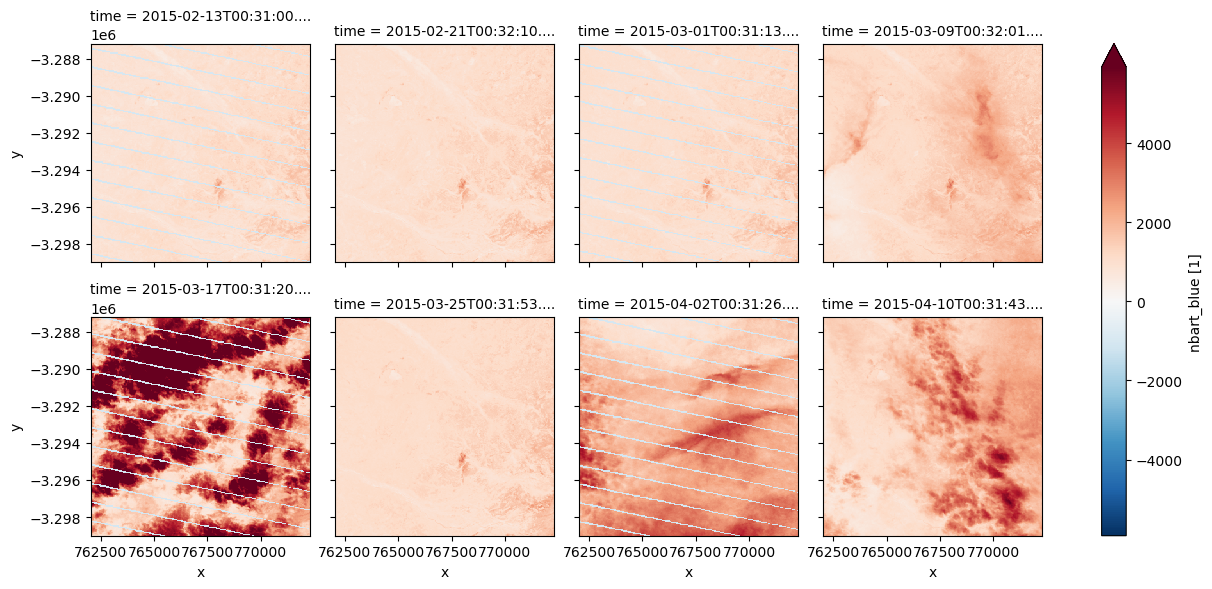

In [4]:
# Select spatiotemporal query (can be replaced with scene path/row)
query_params = dict(x=(140, 140.1), y=(-30, -30.1), time=(start_time, end_time))

# Set load params (measurements to load, Dask chunking, resampling etc)
load_params = dict(measurements=bands, dask_chunks={})

# Lazily load data
ds = dc.load(product=products, **query_params, **load_params)

# Plot
ds.nbart_blue.isel(time=slice(4, 12)).plot.imshow(col="time", robust=True, col_wrap=4)

## Fmask cloud and shadow mask
Based on content from: https://docs.dea.ga.gov.au/notebooks/How_to_guides/Masking_data.html

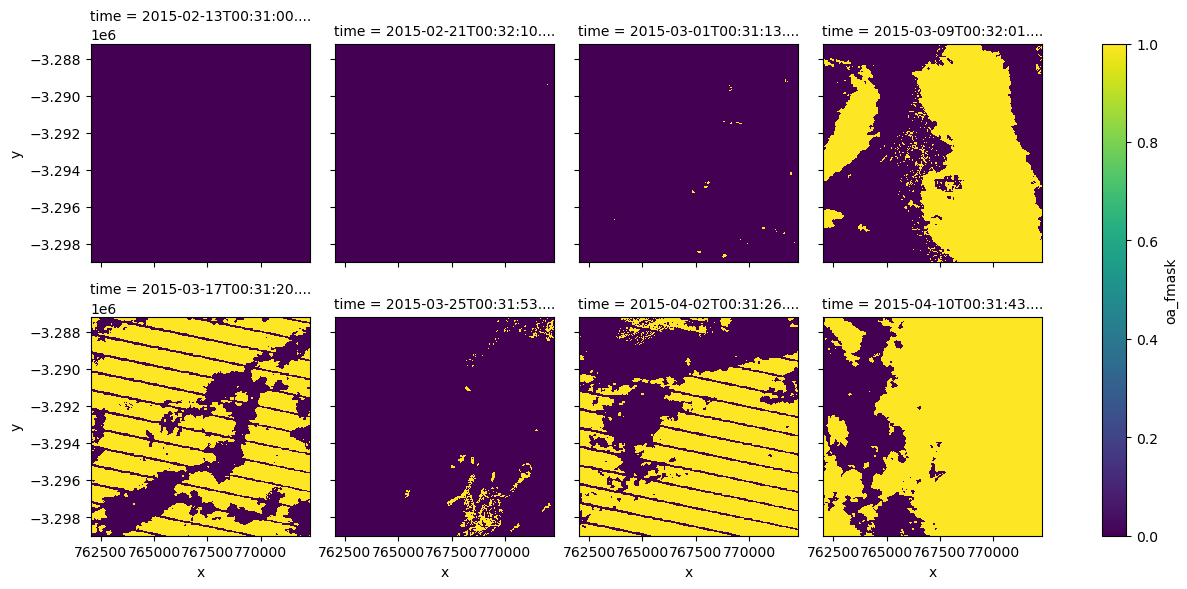

In [5]:
# Identify pixels that are either "cloud" or "cloud_shadow"
cloud_shadow_mask = make_mask(ds.oa_fmask, fmask="cloud") | make_mask(
    ds.oa_fmask, fmask="shadow"
)

# Plot
cloud_shadow_mask.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

### Applying dilation using `mask_cleanup`

In [26]:
def get_std(buffer_size, ds): 
    # Dilate all cloud and cloud shadow pixels by n pixels (uses a circular disk)
    cloud_shadow_buffered = mask_cleanup(
        mask=cloud_shadow_mask, mask_filters=[("dilation", buffer_size)]
    )
    
    # Apply the mask
    clear_buffered = ds.where(~cloud_shadow_buffered)
    
    # load into memory
    clear_buffered.load()
    
    # calculate mean of std for time series
    nbart_red_std = int(clear_buffered.nbart_red.std("time").mean())
    nbart_blue_std = int(clear_buffered.nbart_blue.std("time").mean())
    return nbart_blue_std, nbart_red_std

nbart_blue_buffer_std = {}
nbart_red_buffer_std = {}
std = []

for buffer in range(start_buffering, end_buffering):    
    nbart_blue_buffer_std[buffer],  nbart_red_buffer_std[buffer]= get_std(buffer,ds)
    print(f"Buffer in pixels: {buffer}, nbart_blue_std: {nbart_blue_buffer_std[buffer]}, nbart_red_std: {nbart_red_buffer_std[buffer]}")

Buffer in pixels: 0, nbart_blue_std: 466, nbart_red_std: 761
Buffer in pixels: 1, nbart_blue_std: 434, nbart_red_std: 735
Buffer in pixels: 2, nbart_blue_std: 413, nbart_red_std: 706
Buffer in pixels: 3, nbart_blue_std: 407, nbart_red_std: 700
Buffer in pixels: 4, nbart_blue_std: 405, nbart_red_std: 697
Buffer in pixels: 5, nbart_blue_std: 402, nbart_red_std: 694
Buffer in pixels: 6, nbart_blue_std: 401, nbart_red_std: 693
Buffer in pixels: 7, nbart_blue_std: 400, nbart_red_std: 691
Buffer in pixels: 8, nbart_blue_std: 399, nbart_red_std: 690
Buffer in pixels: 9, nbart_blue_std: 397, nbart_red_std: 688
Buffer in pixels: 10, nbart_blue_std: 396, nbart_red_std: 687
Buffer in pixels: 11, nbart_blue_std: 395, nbart_red_std: 685
Buffer in pixels: 12, nbart_blue_std: 394, nbart_red_std: 684
Buffer in pixels: 13, nbart_blue_std: 393, nbart_red_std: 683
Buffer in pixels: 14, nbart_blue_std: 392, nbart_red_std: 682
Buffer in pixels: 15, nbart_blue_std: 391, nbart_red_std: 680
Buffer in pixels: 

### Plot standard deviation vs buffer size in pixels

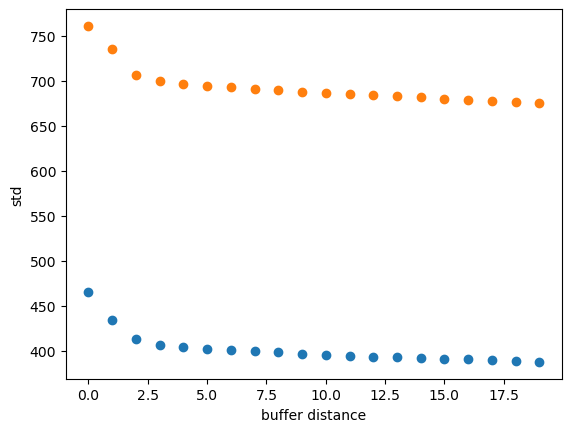

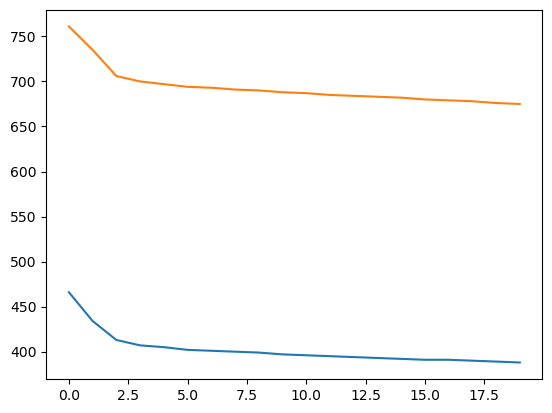

In [27]:
import matplotlib.pyplot as plt

plt.xlabel("buffer distance")
plt.ylabel("std")

plt.scatter(list(nbart_blue_buffer_std.keys()), list(nbart_blue_buffer_std.values()))
plt.scatter(list(nbart_red_buffer_std.keys()), list(nbart_red_buffer_std.values()))
plt.show()

plt.plot(list(nbart_blue_buffer_std.keys()), list(nbart_blue_buffer_std.values()))
plt.plot(list(nbart_red_buffer_std.keys()), list(nbart_red_buffer_std.values()))
plt.show()

### Calculate the gradient of above

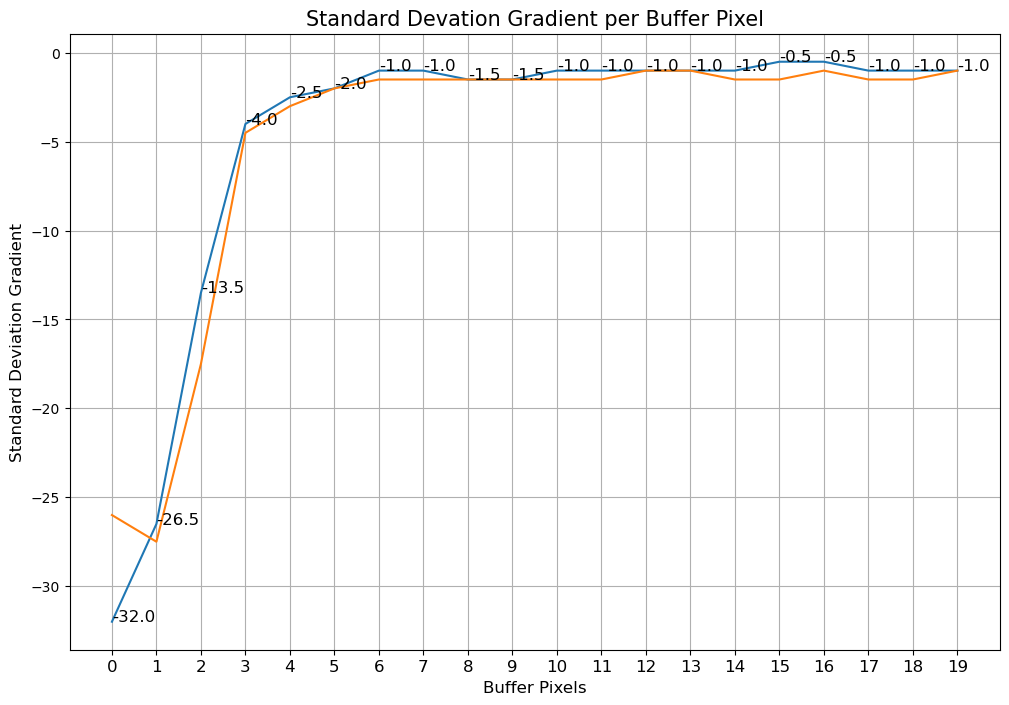

In [28]:
import numpy as np
y_blue = np.array(list(nbart_blue_buffer_std.values()), dtype=np.float64)
j_blue = np.gradient(y_blue)
x = list(nbart_blue_buffer_std.keys())

y_red = np.array(list(nbart_red_buffer_std.values()), dtype=np.float64)
j_red = np.gradient(y_red)

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x, j_blue)
plt.plot(x, j_red)


plt.xlabel("Buffer Pixels", size=12)
plt.ylabel("Standard Deviation Gradient", size=12)
plt.title("Standard Devation Gradient per Buffer Pixel", size=15)
for index in range(len(x)):
  ax.text(x[index], j_blue[index], j_blue[index], size=12)
plt.grid()
plt.xticks([i for i in range(20)], size=12)
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2023

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)